In [1]:
# 忽略warnings
import warnings 
warnings.filterwarnings('ignore') 

# 导入Python通用库
import matplotlib.pyplot as plt
import numpy as np
import os

# 强制使用CPU
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

# 导入TF 2.0并设置GPU
import tensorflow as tf
# Conv setup this configuration
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
# 导入Keras库
from tensorflow import keras
# 设置使用GPU显存的比例
from keras.backend.tensorflow_backend import set_session
# LSTM/GRU setup this configuration
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.75
# tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config)) 
# 导入模型、优化器、损失函数等等
from keras import preprocessing
from keras import regularizers
from keras import optimizers
from keras import metrics
from keras import models
from keras import losses
from keras import layers
# 导入Keras字符处理模块
from keras.layers import Dense, Embedding, SimpleRNN, LSTM, GRU
from keras.preprocessing import sequence
from keras.models import Sequential
# 导入数据集
from keras.datasets import imdb

Using TensorFlow backend.


# 06. 深度学习用于文本和序列
本章将介绍使用深度学习模型处理文本、时间序列和一般的序列数据。用于处理序列的两种基本的深度学习算法分别是`循环神经网络`（recurrent neural network）和`一维卷积神经网络`（1D convnet），后者是上一章介绍的二维卷积神经网络的一维版本。本章将讨论这两种方法。

这些算法的应用包括：
+ 文档分类和时间序列分类，比如识别文章的主题或书的作者
+ 时间序列对比，比如估测两个文档或两支股票行情的相关程度
+ 序列到序列的学习，比如将英语翻译成法语
+ 情感分析，比如将推文或电影评论的情感划分为正面或负面
+ 时间序列预测，比如根据某地最近的天气数据来预测未来天气

以下是将要用到的数据和生成器：

In [2]:
f = open("./data/jena_climate/jena_climate_2009_2016.csv")
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


从输出可以看出，共有420551行数据（每行是一个时间步，记录了一个日期和14个与天气有关的值）。

接下来，将420551行数据转换成一个`Numpy`数组、以及标准化数据：

In [3]:
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [4]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [5]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [6]:
lookback = 1440
step = 6
delay = 144
batch_size = 256
# batch_size = 128

train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, step=step, batch_size=batch_size)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, step=step, batch_size=batch_size)

# 为了查看整个验证集，需要从val_gen中抽取多少次
val_steps = (300000 - 200001 - lookback)  //batch_size
# 为了查看整个测试集，需要从test_gen中抽取多少次
test_steps = (len(float_data) - 300001 - lookback)  //batch_size 

## 6.4 用卷积神经网络处理序列
`卷积神经网络`在计算机视觉问题上表现出色，原因在于它能够进行卷积运算，从局部输入图块中提取特征，并能够将表示模块化，同时可以高效地利用数据。这些性质让卷积神经网络在计算机视觉领域表现优异，同样也让它对序列处理特别有效。时间可以被看作一个空间维度，就像二维图像的高度或宽度。

对于某些序列处理问题，这种`一维卷积神经网络`的效果可以媲美`RNN`，而且计算代价通常要小很多。最近，`一维卷积神经网络`［通常与`空洞卷积核`（dilated kernel）一起使用］已经在音频生成和机器翻译领域取得了巨大成功。除了这些具体的成就，人们还早已知道，对于文本分类和时间序列预测等简单任务，小型的`一维卷积神经网络`可以替代`RNN`，而且速度更快。

### 6.4.1 理解序列数据的一维卷积
前面介绍的卷积层都是二维卷积，从图像张量中提取二维图块并对每个图块应用相同的变换。按照同样的方法，你也可以使用一维卷积，从序列中提取局部一维序列段（即子序列），见`图6-26`。

<img src="images/06_26.png" style="width:500px;"/>

这种一维卷积层可以识别序列中的局部模式。因为对每个序列段执行相同的输入变换，所以在句子中某个位置学到的模式稍后可以在其他位置被识别，这使得一维卷积神经网络具有平移不变性（对于时间平移而言）。举个例子，使用大小为5的卷积窗口处理字符序列的一维卷积神经网络，应该能够学习长度不大于5的单词或单词片段，并且应该能够在输入句子中的任何位置识别这些单词或单词段。因此，字符级的一维卷积神经网络能够学会单词构词法。

### 6.4.2 序列数据的一维池化
你已经学过二维池化运算，比如二维平均池化和二维最大池化，在卷积神经网络中用于对图像张量进行空间下采样。一维也可以做相同的池化运算：从输入中提取一维序列段（即子序列），然后输出其最大值或平均值。与二维卷积神经网络一样，该运算也是用于降低一维输入的长度（子采样）。

### 6.4.3 实现一维卷积神经网络
`Keras`中的一维卷积神经网络是`Conv1D`层，其接口类似于`Conv2D`。它接收的输入是形状为`(samples, time, features)`的三维张量，并返回类似形状的三维张量。卷积窗口是时间轴上的一维窗口（时间轴是输入张量的第二个轴）。

我们来构建一个简单的两层一维卷积神经网络，并将其应用于我们熟悉的`IMDB`情感分类任务。

In [7]:
max_features = 10000
max_len = 500

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


一维卷积神经网络的架构与第5章的二维卷积神经网络相同，它是`Conv1D`层和`MaxPooling1D`层的堆叠，最后是一个全局池化层或`Flatten`层，将三维输出转换为二维输出，让你可以向模型中添加一个或多个`Dense`层，用于分类或回归。

不过二者有一点不同：一维卷积神经网络可以使用更大的卷积窗口。对于二维卷积层，$3\times 3$的卷积窗口包含$3 \times 3 = 9$个特征向量；但对于一维卷积层，大小为3的卷积窗口只包含3个卷积向量。因此，你可以轻松使用大小等于7或9的一维卷积窗口。

In [8]:
model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
____________________________________________

In [9]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 7s 362us/step - loss: 7.7364 - acc: 0.4985 - val_loss: 7.6168 - val_acc: 0.5062 loss: 7.7500 - acc: 0.49 - ETA: 0s - loss: 7.7524 - ac
Epoch 2/10
20000/20000 [==============================] - 6s 283us/step - loss: 7.7364 - acc: 0.4985 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 3/10
20000/20000 [==============================] - 6s 283us/step - loss: 7.7364 - acc: 0.4985 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 4/10
20000/20000 [==============================] - 6s 283us/step - loss: 7.7364 - acc: 0.4985 - val_loss: 7.6168 - val_acc: 0.5062 4s - loss: 7.6869 - acc: 0 - ETA: 3s - loss: 7.
Epoch 5/10
20000/20000 [==============================] - 6s 283us/step - loss: 7.7364 - acc: 0.4985 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 6/10
20000/20000 [==============================] - 6s 284us/step - loss: 7.7364 - acc: 0.4985 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 7/10
20000/200

绘制模型的训练结果和验证结果：

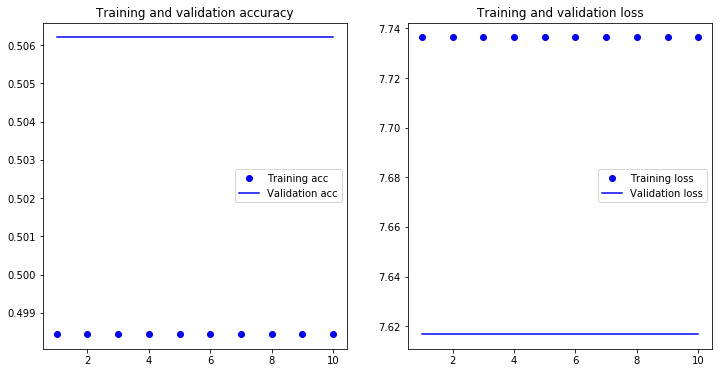

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

验证精度略低于`LSTM`，但在`CPU`和`GPU`上的运行速度都要更快。现在，你可以使用正确的轮数（4轮）重新训练这个模型，然后在测试集上运行。这个结果可以让我们确信，在单词级的情感分类任务上，一维卷积神经网络可以替代循环网络，并且速度更快、计算代价更低。

### 6.4.4 结合CNN和RNN来处理长序列
一维卷积神经网络分别处理每个输入序列段，所以它对时间步的顺序不敏感（这里所说顺序的范围要大于局部尺度，即大于卷积窗口的大小），这一点与RNN不同。当然，为了识别更长期的模式，你可以将许多卷积层和池化层堆叠在一起，这样上面的层能够观察到原始输入中更长的序列段，但这仍然不是一种引入顺序敏感性的好方法。想要证明这种方法的不足，一种方法是在温度预测问题上使用一维卷积神经网络，在这个问题中顺序敏感性对良好的预测结果非常关键。以下示例复用了前面定义的这些变量：`float_data`、`train_gen`、`val_gen`和`val_steps`。

In [11]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=optimizers.RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 11s 23ms/step - loss: 0.4071 - val_loss: 0.1551
Epoch 2/20
500/500 [==============================] - 11s 21ms/step - loss: 0.3536 - val_loss: 0.4131
Epoch 3/20
500/500 [==============================] - 11s 21ms/step - loss: 0.3287 - val_loss: 0.4748
Epoch 4/20
500/500 [==============================] - 11s 22ms/step - loss: 0.3118 - val_loss: 0.3063
Epoch 5/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2998 - val_loss: 0.3381
Epoch 6/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2899 - val_loss: 0.2427
Epoch 7/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2818 - val_loss: 0.3303
Epoch 8/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2740 - val_loss: 0.3147
Epoch 9/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2687 - val_loss: 0.2127
Epoch 10/20
500/500 [==============================] - 11s 21ms/step - loss: 0.263

给出了训练和验证的`MAE`：

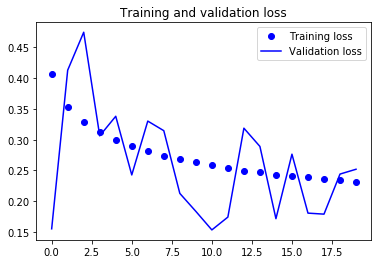

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

验证`MAE`停留在0.4~0.5，使用小型卷积神经网络甚至无法击败基于常识的基准方法。同样，这是因为卷积神经网络在输入时间序列的所有位置寻找模式，它并不知道所看到某个模式的时间位置（距开始多长时间，距结束多长时间等）。对于这个具体的预测问题，对最新数据点的解释与对较早数据点的解释应该并不相同，所以卷积神经网络无法得到有意义的结果。卷积神经网络的这种限制对于`IMDB`数据来说并不是问题，因为对于与正面情绪或负面情绪相关联的关键词模式，无论出现在输入句子中的什么位置，它所包含的信息量是一样的。

要想结合卷积神经网络的速度和轻量与`RNN`的顺序敏感性，一种方法是在`RNN`前面使用一维卷积神经网络作为预处理步骤（见`图6-30`）。对于那些非常长，以至于`RNN`无法处理的序列（比如包含上千个时间步的序列），这种方法尤其有用。卷积神经网络可以将长的输入序列转换为高级特征组成的更短序列（下采样）。然后，提取的特征组成的这些序列成为网络中`RNN`的输入。

<img src="images/06_30.png" style="width:350px;"/>

这种方法在研究论文和实际应用中并不多见，可能是因为很多人并不知道。这种方法非常有效，应该被更多人使用。我们尝试将其应用于温度预测数据集。因为这种方法允许操作更长的序列，所以我们可以查看更早的数据（通过增大数据生成器的`lookback`参数）或查看分辨率更高的时间序列（通过减小生成器的`step`参数）。这里我们任意地将`step`减半，得到时间序列的长度变为之前的两倍，温度数据的采样频率变为每30分钟一个数据点。本示例复用了之前定义的`generator`函数。

In [13]:
# 之前设置为6（每小时一个数据点），现在设置为3（每30分钟一个数据点）
step = 3
lookback = 720 
delay = 144     

train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, step=step)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

下面是模型，开始是两个`Conv1D `层，然后是一个`GRU`层：

In [14]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=optimizers.RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 40s 80ms/step - loss: 377067203077115136.0000 - val_loss: 0.47

KeyboardInterrupt: 

绘制结果：

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

从验证损失来看，这种架构的效果不如只用正则化`GRU`，但速度要快很多。它查看了两倍的数据量，在本例中可能不是非常有用，但对于其他数据集可能非常重要。

### 6.4.5 小结
下面是你应该从本节中学到的要点：
+ 二维卷积神经网络在二维空间中处理视觉模式时表现很好，与此相同，一维卷积神经网络在处理时间模式时表现也很好。对于某些问题，特别是自然语言处理任务，它可以替代`RNN`，并且速度更快
+ 通常情况下，一维卷积神经网络的架构与计算机视觉领域的二维卷积神经网络很相似，它将`Conv1D`层和`MaxPooling1D`层堆叠在一起，最后是一个全局池化运算或展平操作
+ 因为`RNN`在处理非常长的序列时计算代价很大，但一维卷积神经网络的计算代价很小，所以在`RNN`之前使用一维卷积神经网络作为预处理步骤是一个好主意，这样可以使序列变短，并提取出有用的表示交给`RNN`来处理